In [1]:
import numpy as np
import math
from typing import Callable, List, Tuple, Dict, Any, Optional
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
RandomState = np.random.RandomState

In [3]:
class OrderBookSimulator:
    def __init__(
        self,
        K: int,
        lambda_M_buy: float,
        lambda_M_sell: float,
        lambda_L_buy: np.ndarray,   # shape (K,)
        lambda_L_sell: np.ndarray,  # shape (K,)
        lambda_C: np.ndarray,       # shape (K,) cancellation intensity per level (same for both sides; adapt if needed)
        a_inf: float,
        b_inf: float,
        VL_sampler: Callable[[], int], # sample size for limit orders
        VM_sampler: Callable[[], int], # sample size for market orders
        VC_sampler: Callable[[], int], # sample size for cancellations (usually equals 1 but general)
        Xinit: Optional[Dict[str, np.ndarray]] = None,
        random_state: Optional[int] = None
    ):
        """
        Parameters:
          - K: number of visible limits per side
          - lambda_M_buy, lambda_M_sell: market order intensities (buys remove asks)
          - lambda_L_buy, lambda_L_sell: arrays (K,) of intensities for limit orders at relative levels 1..K
          - lambda_C: array (K,) cancellation intensities per level (used as multiplicative factor)
          - a_inf, b_inf: hidden liquidity beyond the visible frame (positive scalars)
          - VL_sampler, VM_sampler, VC_sampler: callables that return an integer volume when called
          - Xinit: optional dict {'asks': array(K,), 'bids': array(K,)} initial book (positive vols)
        """
        assert len(lambda_L_buy) == K and len(lambda_L_sell) == K and len(lambda_C) == K
        self.K = K
        self.lambda_M_buy = float(lambda_M_buy)
        self.lambda_M_sell = float(lambda_M_sell)
        self.lambda_L_buy = np.array(lambda_L_buy, dtype=float)
        self.lambda_L_sell = np.array(lambda_L_sell, dtype=float)
        self.lambda_C = np.array(lambda_C, dtype=float)
        self.a_inf = float(a_inf)
        self.b_inf = float(b_inf)
        self.VL = VL_sampler
        self.VM = VM_sampler
        self.VC = VC_sampler
        self.rng = np.random.RandomState(random_state) if random_state is not None else np.random

        # initialize book
        if Xinit is None:
            # default small book
            self.asks = np.ones(K) * a_inf
            self.bids = np.ones(K) * b_inf
        else:
            self.asks = np.array(Xinit['asks'], dtype=float).copy()
            self.bids = np.array(Xinit['bids'], dtype=float).copy()
            assert len(self.asks) == K and len(self.bids) == K

    # -------------------------
    # Utility / Book operations
    # -------------------------
    def enforce_boundary(self):
        """Ensure last visible levels equal the hidden reservoir when needed."""
        # after shifts we set the last visible slot to the hidden reservoir
        self.asks = np.asarray(self.asks, dtype=float)
        self.bids = np.asarray(self.bids, dtype=float)
        # no extra action necessary: when shifting we explicitly set last to a_inf / b_inf

    def shift_asks_after_consumption(self):
        """Shift ask book left when best ask emptied; fill end with a_inf."""
        # keep shifting while best ask is zero (can happen after large market order)
        while self.asks[0] <= 0:
            # remove level 0 -> shift left
            self.asks[:-1] = self.asks[1:]
            self.asks[-1] = self.a_inf

    def shift_bids_after_consumption(self):
        """Shift bid book left when best bid emptied; fill end with b_inf."""
        while self.bids[0] <= 0:
            self.bids[:-1] = self.bids[1:]
            self.bids[-1] = self.b_inf

    def consume_from_asks(self, volume: float):
        """A buy market order consumes asks from best to deeper levels."""
        v = volume
        i = 0
        while v > 0 and i < self.K:
            consume = min(self.asks[i], v)
            self.asks[i] -= consume
            v -= consume
            if self.asks[i] <= 0:
                # will shift after finishing consumption
                pass
            if self.asks[i] > 0:
                # still liquidity at this level -> done
                break
            i += 1
        # if still leftover v > 0, take from hidden reservoir:
        if v > 0:
            # we model hidden reservoir as infinite in capacity but fixed per-level volume a_inf
            # we subtract from hidden reservoir conceptually, but here we simply ignore beyond K
            # (alternative: reduce a_inf accumulatively if desired)
            v = 0  # assume hidden reservoir absorbs remainder (or you can track it)
        # shift emptied best levels
        self.shift_asks_after_consumption()
        self.enforce_boundary()

    def consume_from_bids(self, volume: float):
        """A sell market order consumes bids from best to deeper levels."""
        v = volume
        i = 0
        while v > 0 and i < self.K:
            consume = min(self.bids[i], v)
            self.bids[i] -= consume
            v -= consume
            if self.bids[i] <= 0:
                pass
            if self.bids[i] > 0:
                break
            i += 1
        if v > 0:
            v = 0
        self.shift_bids_after_consumption()
        self.enforce_boundary()

    def add_limit_ask(self, level_idx: int, volume: float):
        """Add a limit sell (ask) at relative level level_idx in {0..K-1} (1..K in paper)."""
        assert 0 <= level_idx < self.K
        self.asks[level_idx] += volume

    def add_limit_bid(self, level_idx: int, volume: float):
        assert 0 <= level_idx < self.K
        self.bids[level_idx] += volume

    def cancel_ask_at_level(self, level_idx: int, volume: float):
        """Cancel up to 'volume' from ask level; if empties, shift."""
        assert 0 <= level_idx < self.K
        canceled = min(self.asks[level_idx], volume)
        self.asks[level_idx] -= canceled
        # if best ask emptied, shift (only need to shift if level_idx == 0 and now zero)
        if level_idx == 0 and self.asks[0] <= 0:
            self.shift_asks_after_consumption()
        self.enforce_boundary()
        return canceled

    def cancel_bid_at_level(self, level_idx: int, volume: float):
        assert 0 <= level_idx < self.K
        canceled = min(self.bids[level_idx], volume)
        self.bids[level_idx] -= canceled
        if level_idx == 0 and self.bids[0] <= 0:
            self.shift_bids_after_consumption()
        self.enforce_boundary()
        return canceled

    # -------------------------
    # Main simulator
    # -------------------------
    def simulate(self, N_events: int) -> Dict[str, Any]:
        """
        Simulate N_events events (event time).

        Returns:
          history: dict with lists:
             - times: physical times of events (list length N_events)
             - event_types: list of strings
             - event_volumes: list of volumes
             - event_levels: relative levels chosen (1..K) or None
             - asks_history: list of ask arrays snapshots (length N_events)
             - bids_history: list of bid arrays snapshots
        """
        t = 0.0
        times = []
        event_types = []
        event_volumes = []
        event_levels = []
        asks_hist = []
        bids_hist = []
        LambdaC_a_snapshots = []
        LambdaC_b_snapshots = []
        for n in range(N_events):
            # 3: update cancellation intensities (state dependent)
            LambdaC_a = float(np.sum(self.lambda_C * self.asks))
            LambdaC_b = float(np.sum(self.lambda_C * self.bids))
            LambdaC_a_snapshots.append(self.lambda_C * self.asks)
            LambdaC_b_snapshots.append(self.lambda_C * self.bids)
            # total limit arrival intensities per side
            LambdaL_buy = float(np.sum(self.lambda_L_buy))
            LambdaL_sell = float(np.sum(self.lambda_L_sell))
            
            # total market intensities
            LambdaM_buy = float(self.lambda_M_buy)
            LambdaM_sell = float(self.lambda_M_sell)

            # 4: time to next event (exponential with total rate)
            total_rate = LambdaM_buy + LambdaM_sell + LambdaL_buy + LambdaL_sell + LambdaC_a + LambdaC_b
            if total_rate <= 0:
                # no events possible -> break
                print("Total rate zero at step", n)
                break
            # waiting time
            tau = self.rng.exponential(scale=1.0 / total_rate)
            t += tau

            # 5: choose event type
            probs = np.array([LambdaM_buy, LambdaM_sell, LambdaL_buy, LambdaL_sell, LambdaC_a, LambdaC_b], dtype=float) / total_rate
            # categories: 0=buy market (consumes asks), 1=sell market (consumes bids),
            # 2=buy limit (adds to bids), 3=sell limit (adds to asks),
            # 4=cancel ask, 5=cancel bid
            cat = self.rng.choice(6, p=probs)

            # 6: volume
            if cat in (0,1):  # market
                vol = int(self.VM()) if callable(self.VM) else int(self.VM)
            elif cat in (2,3):  # limit
                vol = int(self.VL()) if callable(self.VL) else int(self.VL)
            else:  # cancellation
                vol = int(self.VC()) if callable(self.VC) else int(self.VC)

            chosen_level = None

            # 7-13: price / level selection and apply
            if cat == 0:
                # buy market order (consumes asks)
                self.consume_from_asks(vol)
                event_types.append("M_buy")
                event_volumes.append(vol)
                event_levels.append(None)

            elif cat == 1:
                # sell market (consumes bids)
                self.consume_from_bids(vol)
                event_types.append("M_sell")
                event_volumes.append(vol)
                event_levels.append(None)

            elif cat == 2:
                # buy limit order -> add to bids
                # 9: draw relative price level according to lambda_L_buy vector
                if LambdaL_buy <= 0:
                    # no limit arrival rates on buy side -> ignore
                    event_types.append("L_buy_ignored")
                    event_volumes.append(0)
                    event_levels.append(None)
                else:
                    probs_levels = self.lambda_L_buy / LambdaL_buy
                    lvl = self.rng.choice(self.K, p=probs_levels)  # 0..K-1
                    self.add_limit_bid(lvl, vol)
                    chosen_level = lvl + 1
                    event_types.append("L_buy")
                    event_volumes.append(vol)
                    event_levels.append(chosen_level)

            elif cat == 3:
                # sell limit order -> add to asks
                if LambdaL_sell <= 0:
                    event_types.append("L_sell_ignored")
                    event_volumes.append(0)
                    event_levels.append(None)
                else:
                    probs_levels = self.lambda_L_sell / LambdaL_sell
                    lvl = self.rng.choice(self.K, p=probs_levels)
                    self.add_limit_ask(lvl, vol)
                    chosen_level = lvl + 1
                    event_types.append("L_sell")
                    event_volumes.append(vol)
                    event_levels.append(chosen_level)

            elif cat == 4:
                # cancellation on ask side
                if LambdaC_a <= 0:
                    event_types.append("C_ask_ignored")
                    event_volumes.append(0)
                    event_levels.append(None)
                else:
                    weights = self.lambda_C * self.asks
                    probs_levels = weights / np.sum(weights)
                    lvl = self.rng.choice(self.K, p=probs_levels)
                    canceled = self.cancel_ask_at_level(lvl, vol)
                    chosen_level = lvl + 1
                    event_types.append("C_ask")
                    event_volumes.append(canceled)
                    event_levels.append(chosen_level)

            elif cat == 5:
                # cancellation on bid side
                if LambdaC_b <= 0:
                    event_types.append("C_bid_ignored")
                    event_volumes.append(0)
                    event_levels.append(None)
                else:
                    weights = self.lambda_C * self.bids
                    probs_levels = weights / np.sum(weights)
                    lvl = self.rng.choice(self.K, p=probs_levels)
                    canceled = self.cancel_bid_at_level(lvl, vol)
                    chosen_level = lvl + 1
                    event_types.append("C_bid")
                    event_volumes.append(canceled)
                    event_levels.append(chosen_level)

            # 14: advance time already done (t += tau)
            times.append(t)

            # 15: enforce boundary conditions
            self.asks[-1] = self.a_inf
            self.bids[-1] = self.b_inf
            self.enforce_boundary()

            # record snapshot (copy arrays to avoid aliasing)
            asks_hist.append(self.asks.copy())
            bids_hist.append(self.bids.copy())
        
        return {
            'times': times,
            'event_types': event_types,
            'event_volumes': event_volumes,
            'event_levels': event_levels,
            'asks_history': asks_hist,
            'bids_history': bids_hist,
            'lambdaC_a': LambdaC_a_snapshots,
            'lambdaC_b': LambdaC_b_snapshots
        }

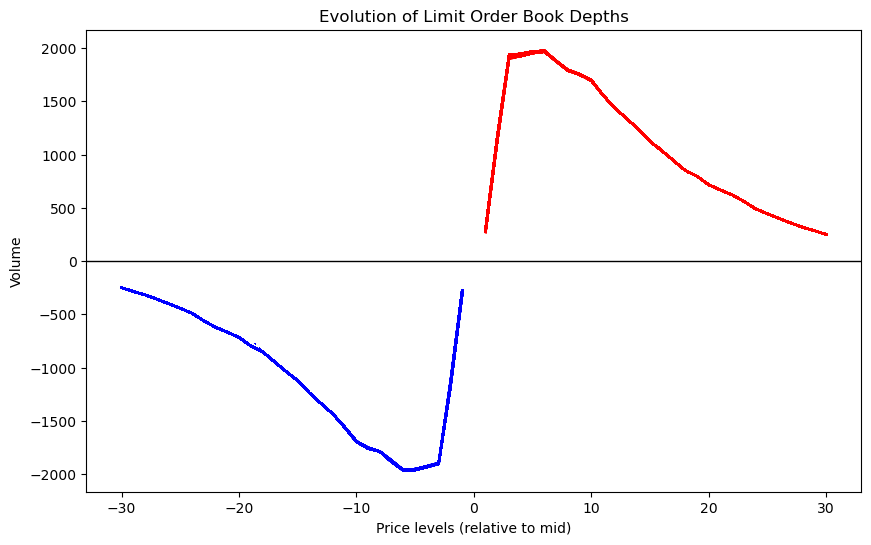

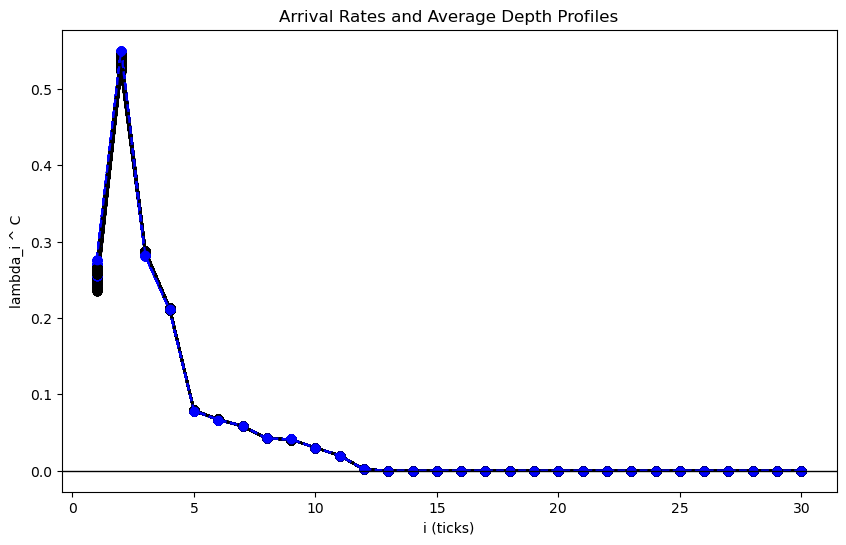

Simulated events: 1000
Last 5 event types: ['C_bid', 'C_bid', 'L_buy', 'C_bid', 'C_ask']
Last asks: [ 308. 1179. 1935. 1943. 1965. 1974. 1880. 1796. 1755. 1696. 1557. 1435.
 1338. 1238. 1122. 1036.  943.  850.  796.  716.  667.  621.  560.  490.
  443.  400.  357.  317.  285.  250.]
Last bids: [ 319. 1187. 1898. 1927. 1960. 1965. 1886. 1788. 1759. 1695. 1561. 1435.
 1338. 1238. 1122. 1036.  943.  850.  796.  716.  667.  621.  560.  490.
  443.  400.  357.  317.  285.  250.]


In [18]:
# -------------------------
# Example samplers & usage
# -------------------------
K = 30
lambda_M_buy = 0.1237
lambda_M_sell = 0.1237
lambda_L_buy = np.array([
    0.2842, 0.5255, 0.2971, 0.2307, 0.0826, 0.0682, 0.0631, 0.0481, 0.0462, 0.0321,
    0.0178, 0.0015, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
])
lambda_L_sell = np.array([
    0.2842, 0.5255, 0.2971, 0.2307, 0.0826, 0.0682, 0.0631, 0.0481, 0.0462, 0.0321,
    0.0178, 0.0015, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
])
lambda_C = np.array([
    0.8636, 0.4635, 0.1487, 0.1096, 0.0402, 0.0341, 0.0311, 0.0237, 0.0233, 0.0178,
    0.0127, 0.0012, 0.0001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
    0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
])*1e-3  # per-level cancel intensity multiplier
a_inf = 250.0
b_inf = 250.0

# volume samplers: simple examples (can be replaced by any callable)
def VL_sampler():
    # geometric-like small sizes: 1 with prob 0.7, 2 with prob 0.2, 5 with prob 0.1
    return int(np.random.choice([1,2,5], p=[0.7,0.2,0.1]))

def VM_sampler():
    return int(np.random.choice([1,2], p=[0.9,0.1]))

def VC_sampler():
    return 1  # cancel single unit
# def VL_sampler():
#     return np.random.lognormal(4.47, 0.83)

# def VM_sampler():
#     return np.random.lognormal(4.00, 1.19)

# def VC_sampler():
#     return np.random.lognormal(4.48, 0.82)
# initial book: small nonzero visible book
Xinit = {
    'asks': np.array([
            276, 1129, 1896, 1924, 1951, 1966, 1873, 1786, 1752, 1691,
            1558, 1435, 1338, 1238, 1122, 1036, 943, 850, 796, 716,
            667, 621, 560, 490, 443, 400, 357, 317, 285, 249
        ], dtype=float),
    'bids': np.array([
            276, 1129, 1896, 1924, 1951, 1966, 1873, 1786, 1752, 1691,
            1558, 1435, 1338, 1238, 1122, 1036, 943, 850, 796, 716,
            667, 621, 560, 490, 443, 400, 357, 317, 285, 249
        ], dtype=float)
}

sim = OrderBookSimulator(
    K=K,
    lambda_M_buy=lambda_M_buy,
    lambda_M_sell=lambda_M_sell,
    lambda_L_buy=lambda_L_buy,
    lambda_L_sell=lambda_L_sell,
    lambda_C=lambda_C,
    a_inf=a_inf,
    b_inf=b_inf,
    VL_sampler=VL_sampler,
    VM_sampler=VM_sampler,
    VC_sampler=VC_sampler,
    Xinit=Xinit,
    random_state=42
)

history = sim.simulate(N_events=1000)
ask_snapshots = history['asks_history']
bid_snapshots = history['bids_history']
time_snapshots = history['times']

# Generating a static plot
plt.figure(figsize=(10, 6))
for idx, (ask, bid, t) in enumerate(zip(ask_snapshots, bid_snapshots, time_snapshots)):
    x_ask = np.arange(1, K + 1)
    x_bid = -np.arange(1, K + 1)
    plt.plot(x_ask, ask, color='red', alpha=0.2 + 0.8 * idx / len(ask_snapshots))
    plt.plot(x_bid, -bid, color='blue', alpha=0.2 + 0.8 * idx / len(bid_snapshots))
plt.axhline(0, color='black', lw=1)
plt.title("Evolution of Limit Order Book Depths")
plt.xlabel("Price levels (relative to mid)")
plt.ylabel("Volume")
plt.show()
# lambda i c wrt ticks
lambdaCi_a = history['lambdaC_a']
lambdaCi_b = history['lambdaC_b']
plt.figure(figsize=(10, 6))
for idx, (ask, bid) in enumerate(zip(lambdaCi_a, lambdaCi_b)):
    x_ask = np.arange(1, K + 1)
    x_bid = np.arange(1, K + 1)
    plt.plot(x_ask, ask, marker='o', linestyle='-', color='black', alpha=0.2 + 0.8 * idx / len(lambdaCi_a))
    plt.plot(x_bid, bid, marker='o', linestyle='--', color='blue', alpha=0.2 + 0.8 * idx / len(lambdaCi_b))
plt.axhline(0, color='black', lw=1)
plt.title("Arrival Rates and Average Depth Profiles")
plt.ylabel("lambda_i ^ C")
plt.xlabel("i (ticks)")
plt.show()
# Quick checks
print("Simulated events:", len(history['times']))
print("Last 5 event types:", history['event_types'][-5:])
print("Last asks:", history['asks_history'][-1])
print("Last bids:", history['bids_history'][-1])

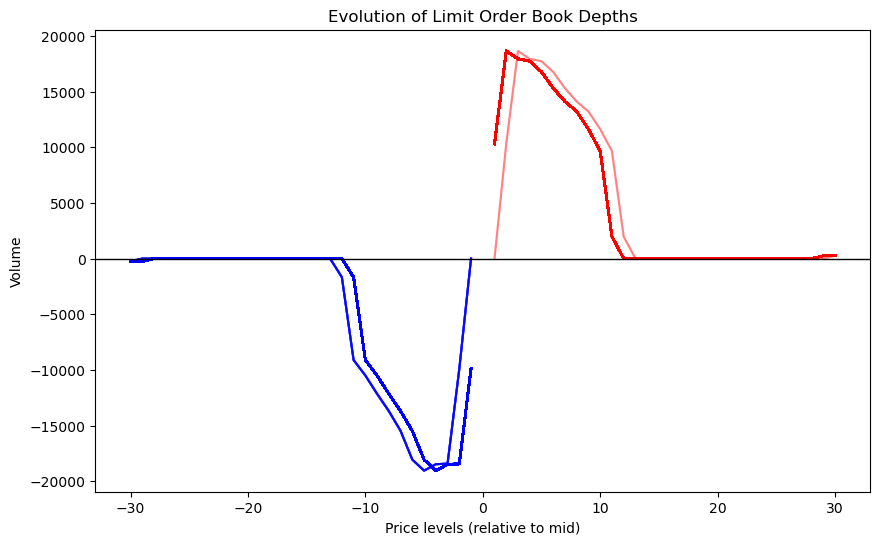

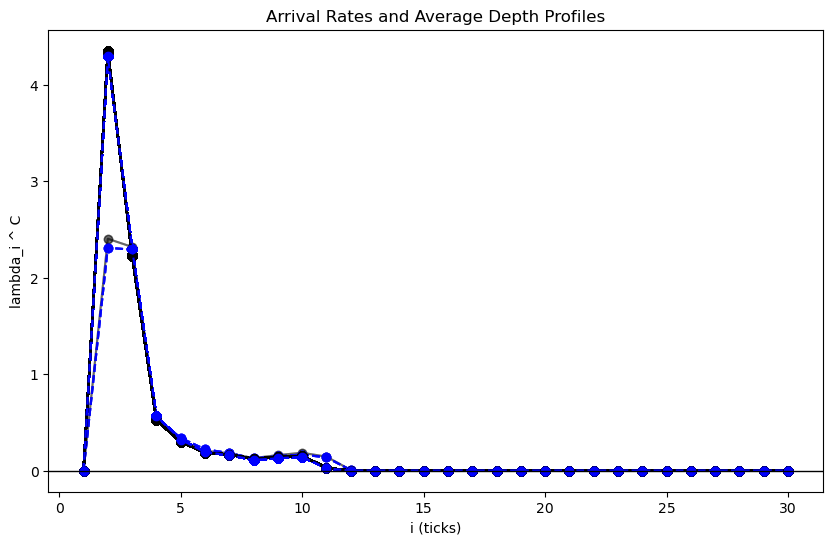

Simulated events: 1000
Last 5 event types: ['C_ask', 'C_ask', 'C_bid', 'C_ask', 'C_ask']
Last asks: [1.0294e+04 1.8628e+04 1.7947e+04 1.7744e+04 1.6771e+04 1.5311e+04
 1.4113e+04 1.3216e+04 1.1624e+04 9.6610e+03 1.9820e+03 3.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.5000e+02 2.5000e+02]
Last bids: [9.8860e+03 1.8429e+04 1.8485e+04 1.9052e+04 1.8063e+04 1.5486e+04
 1.3702e+04 1.2152e+04 1.0512e+04 9.1140e+03 1.6730e+03 2.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00
 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 2.5000e+02 2.5000e+02]


In [21]:
K = 30
lambda_M_buy  = 0.71397759926076
lambda_M_sell = 0.71397759926076
lambda_L_values = np.array([
    0.0,2.8007178388671097,2.244475998202834,0.605750612361384,0.3152151057728716,0.28615514482851795,0.20290690377028123,
    0.13066298615788435,0.12581253679437826,0.1872017042893254,0.12158174836277383, 0.02126078024972934,0.0001709409467314922,
    6.410285502430958e-05,0.0,6.410285502430958e-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
])
lambda_L_buy  = lambda_L_values.copy()
lambda_L_sell = lambda_L_values.copy()
lambda_C = np.array([
    0.0,0.00023303166981948292,0.0001243129589140864,2.9647456575127934e-05,1.7837667750180147e-05,1.231112880930371e-05,
    1.180399268629295e-05,9.258147335300392e-06,1.225915266555177e-05,1.5996578427212917e-05,1.5071785133331117e-05,
    3.8585263348863975e-06,4.523686905862371e-05,0.0,0.0,0.0,0.0,0.0,0.04763305093370266,0.09526610186740532,0.285798305602216,
    0.285798305602216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
]) # per-level cancel intensity multiplier
a_inf = 250.0
b_inf = 250.0

# volume samplers: simple examples (can be replaced by any callable)
def VL_sampler():
    # geometric-like small sizes: 1 with prob 0.7, 2 with prob 0.2, 5 with prob 0.1
    return int(np.random.choice([1,2,5], p=[0.7,0.2,0.1]))

def VM_sampler():
    return int(np.random.choice([1,2], p=[0.9,0.1]))

def VC_sampler():
    return 1  # cancel single unit

Xinit = {
    'asks': np.array([    0, 10312, 18650, 17932, 17733, 16765, 15302, 14105, 13214,
       11631,  9661,  1973,     3,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0], dtype=float),
    'bids': np.array([    0,  9912, 18417, 18472, 19045, 18059, 15478, 13697, 12150,
       10500,  9113,  1670,     2,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0], dtype=float)
}

sim = OrderBookSimulator(
    K=K,
    lambda_M_buy=lambda_M_buy,
    lambda_M_sell=lambda_M_sell,
    lambda_L_buy=lambda_L_buy,
    lambda_L_sell=lambda_L_sell,
    lambda_C=lambda_C,
    a_inf=a_inf,
    b_inf=b_inf,
    VL_sampler=VL_sampler,
    VM_sampler=VM_sampler,
    VC_sampler=VC_sampler,
    Xinit=Xinit,
    random_state=42
)

history = sim.simulate(N_events=1000)
ask_snapshots = history['asks_history']
bid_snapshots = history['bids_history']
time_snapshots = history['times']

# Generating a static plot
plt.figure(figsize=(10, 6))
for idx, (ask, bid, t) in enumerate(zip(ask_snapshots, bid_snapshots, time_snapshots)):
    x_ask = np.arange(1, K + 1)
    x_bid = -np.arange(1, K + 1)
    plt.plot(x_ask, ask, color='red', alpha=0.2 + 0.8 * idx / len(ask_snapshots))
    plt.plot(x_bid, -bid, color='blue', alpha=0.2 + 0.8 * idx / len(bid_snapshots))
plt.axhline(0, color='black', lw=1)
plt.title("Evolution of Limit Order Book Depths")
plt.xlabel("Price levels (relative to mid)")
plt.ylabel("Volume")
plt.show()
# lambda i c wrt ticks
lambdaCi_a = history['lambdaC_a']
lambdaCi_b = history['lambdaC_b']
plt.figure(figsize=(10, 6))
for idx, (ask, bid) in enumerate(zip(lambdaCi_a, lambdaCi_b)):
    x_ask = np.arange(1, K + 1)
    x_bid = np.arange(1, K + 1)
    plt.plot(x_ask, ask, marker='o', linestyle='-', color='black', alpha=0.2 + 0.8 * idx / len(lambdaCi_a))
    plt.plot(x_bid, bid, marker='o', linestyle='--', color='blue', alpha=0.2 + 0.8 * idx / len(lambdaCi_b))
plt.axhline(0, color='black', lw=1)
plt.title("Arrival Rates and Average Depth Profiles")
plt.ylabel("lambda_i ^ C")
plt.xlabel("i (ticks)")
plt.show()
# Quick checks
print("Simulated events:", len(history['times']))
print("Last 5 event types:", history['event_types'][-5:])
print("Last asks:", history['asks_history'][-1])
print("Last bids:", history['bids_history'][-1])